# Tutorial: Modeling hydrogen solubility in metals

### Example case: Al

#### 0. Import reqiured libraries

In [ ]:
# !pip install siman

In [ ]:
import siman #program package to manage DFT calculations https://github.com/dimonaks/siman
from siman.calc_manage import smart_structure_read, get_structure_from_matproj
from siman.calc_manage import add, res
# Update configurations
from siman import header
from siman.database import write_database, read_database
from siman.set_functions import read_vasp_sets
from siman.header import db
from siman.header import _update_configuration
_update_configuration('../project_conf.py')
read_database() # read saved database if available
from pydoc import importfile
project_sets = importfile('../project_sets.py')
# import project_sets # should be after read_database
varset = read_vasp_sets(project_sets.user_vasp_sets, override_global = 0) #read user sets

header.PATH2PROJECT = 'icys_2024/tutorial_1_defects/'
header.PATH2EDITOR = 'notepad.exe'



#### 1. Get structure from POSCAR structure file

In [ ]:
# use siman function to read structure into st object
Al = smart_structure_read('data/poscars/POSCAR_Al')

#### 2. Make a single point calculation

In [ ]:
# INCAR file parameters - define set 'sp' # just nsw = 1, encut 300
varset_sp = read_vasp_sets([('sp', 'static', {'ISIF':2, 'NSW':1, 'ENCUT':300, 
                                "ENAUG": 450, "IBRION": -1}, 'override')])

In [ ]:
# do a single point calculation for primitive cell (one SCF step)
add('Al', 'sp', 1, input_st=Al, it_folder='H_solubility', up="up2", run=0, cluster='razor64')

In [ ]:
# use function res() to read results
res('Al', 'sp', 1)

In [ ]:
# INCAR file parameters - define set 'opt' 
varset_opt = read_vasp_sets([('opt', 'sp', {'ISIF':2, 'NSW':20, 'IBRION':1, 
                                                "POTIM": 0.3, "EDIFFG": -0.05}, 'override')])

In [ ]:
# optimize primitive cell
add('Al', 'opt', 1, input_st=Al, it_folder='H_solubility', up="up2", run=2, cluster='razor64')

In [ ]:
res('Al', 'opt', 1, up="up2")

#### 3. Create supercell and add H interstitial defects (octahedral & tetrahedral voids)

In [ ]:
from siman.geo import supercell

In [ ]:
# use supercell() siman function to create supercell
# take the result of single point calculation as initial structure

# recommended supercell sizes can be found in cheatsheet

Al_sc = supercell(db['Al.opt.1'].end, [10, 10, 10])
Al_sc.write_poscar('POSCAR_Al_sc')

In [ ]:
# add H atom to the created supercell
# create two structures - one with H in octahedral void, other - with H in tetrahedral void

Al_sc_octH = Al_sc.add_atom(element='H', xr=[1/4, 1/4, 1/4])  
Al_sc_tetH = Al_sc.add_atom(element='H', xr=[5/8, 1/8, 1/8]) 

In [ ]:
# write poscars and make sure you got the right H positions
Al_sc_octH.write_poscar('POSCAR_Al_sc_octH')
Al_sc_tetH.write_poscar('POSCAR_Al_sc_tetH')

#### octahedral & tetrahedral positions for H (fcc):

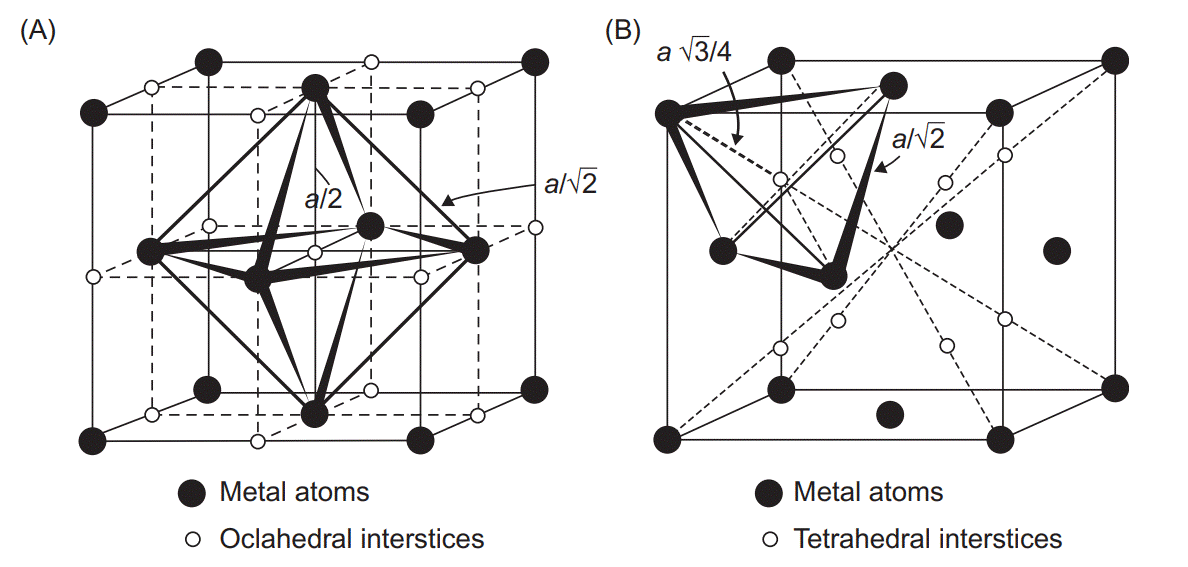

#### 4. Optimize geometry of supercells with H defects

In [ ]:
# use function add() to add calculations to cluster (equation of state)
add('Al_sc_octH', 'opt', 1, input_st=Al_sc_octH, it_folder='H_solubility', run=1, cluster='razor64')
add('Al_sc_tetH', 'opt', 1, input_st=Al_sc_tetH, it_folder='H_solubility', run=1, cluster='razor64')

In [ ]:
# use function res() to read results
res('Al_sc_octH', 'opt', 1)
res('Al_sc_tetH', 'opt', 1)

#### 5. Equation of state for Al & Al sc with H in octahedral void

We will not make this calculation right now because it needs some time \
Here is the syntax of volume scan method:

In [ ]:
st_Al = smart_structure_read('data/poscars/POSCAR_Al')

In [ ]:
add('Al', 'opt', 1, input_st = st_Al, it_folder = 'volume_scan', calc_method = 'uniform_scale',
    n_scale_images=5, scale_region = (-5, 5), run = 1, cluster='razor64')

In [ ]:
# res('Al.su', 'opt', list(range(1,8))+[100], up = 'up', show = 'fit', analys_type = 'fit_a')


Let's turn directly to the results. \
db['Al.su.opt.100'].e0 = -14.9993 eV \
Equation of state for Al unit cell: 

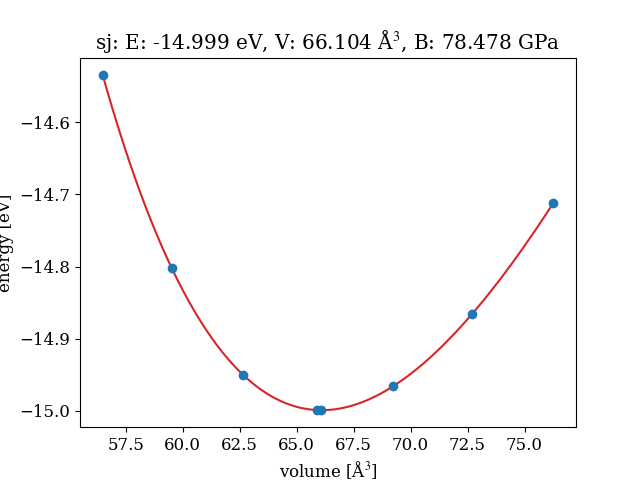

Same calculation for Al with H defect in octehedral void: \
db['Al_sc_octH.su.opt.100'].e0 = -122.501 eV

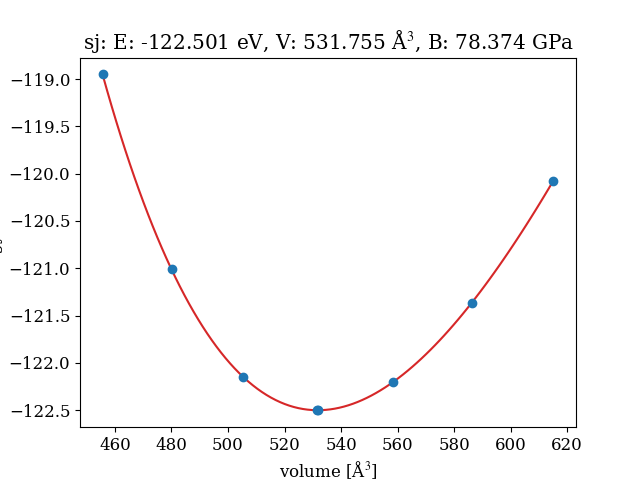

### 6. Calculate H defect formation energy (oct & tet)



$
E_{\mathrm{defect\,formation}}(\mathrm{H}) = E_{\mathrm{sc+H}} - \frac{\mathrm{natom(sc+H)}-1}{\mathrm{natom(st)}} \cdot E_{\mathrm{st}} - \frac{1}{2} \cdot E_{\mathrm{H_2}}
$

sc+H = supercell with H defect \
st = primitive cell structure

##### 6.1. Calculate H2 reference energy

In [ ]:
# a modified parameters set for molecule calculations
varset_mol_opt = read_vasp_sets([('opt_mol', 'static', {'ISIF':2, 'NSW':20, 'IBRION':1, 
                                                        'ENCUT':300, 'KSPACING':10., 'add_nbands':2, 'SIGMA':0.01}, 'override')])

In [ ]:
# read POSCAR_H2, add 'opt_mol' calculation to cluster
H2 = smart_structure_read('data/poscars/POSCAR_H2')

In [ ]:
add('H2', 'opt_mol', 1, input_st=H2, it_folder='H_solubility', run=1, cluster='razor64')

In [ ]:
# read results
# you can just use this energy in individual task, no need to re-calculate
res('H2', 'opt_mol', 1)

##### 6.2. Now calculate defect formation energy

In [ ]:
# calculate defect formation energy
natom_sc = db['Al_sc_octH.opt.1'].end.natom - 1
natom_st = db['Al.opt.1'].end.natom

Hoct_en = db['Al_sc_octH.opt.1'].e0 - (natom_sc / natom_st) * db['Al.opt.1'].e0 - 0.5 * db['H2.opt_mol.1'].e0
Htet_en = db['Al_sc_tetH.opt.1'].e0 - (natom_sc / natom_st) * db['Al.opt.1'].e0 - 0.5 * db['H2.opt_mol.1'].e0

print('H oct formation energy = {:3.3f} eV, H tet formation energy = {:3.3f} eV'.format(Hoct_en, Htet_en))

#### 7. Compare formation energy of H defect in oct & tet positions

In [ ]:
# get the difference between oct & tet H defect formation energies
en_dif = Hoct_en - Htet_en

print('Difference in formation oct & tet H interstitial defect: = {:3.3f} eV'.format(en_dif))

In [ ]:
write_database()